# Logistic Regression Classifier

I've written my classifier as a class, so that I can re-use the plotting functions on the sklearn model as well. I've written out my code so that you can switch between the two classifiers and compare the graphs below. There's a global variable after my import statements that you can set to switch between my classifier and sklearns. I had trouble getting my code to generate misclassification rates for the sklearn classifier, so I've left that out of this program.

In [192]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

USE_SKLEARN = False
THRESH = 0.5

def loadSynthetic(n):
    """
        Takes a number, returns a pandas dataframe
    """
    return pd.read_csv("../data/synthetic-" + str(n) + ".csv", header=None)

def prepData(d):
    """
        expects pandas dataframe, returns train_features, test_features, train_labels, test_labels
    """
    features = d.iloc[:,0:-1]
    labels = d.iloc[:, -1]
    return train_test_split(features, labels, test_size=0.33, random_state=44)

# Logistic Regression Class
This is the code for my logistic regression classifier. I tried to make the functions somewhat similar to the API that sklearn provides with their linear regression classifier, but I don't have the full api implemented. You have the option of using the activation function or the net_input function to determine your predictions (since these two are equivalent if you use a threshold of .5 for the activation function).

In [193]:
class MyLogisticRegression(object):
    """
        learn : learning rate for gradient descent
        iterations: number of iterations for gradient descent
    """
    def __init__(self, learn=0.01, iterations=50):
        self.learn = learn
        self.iterations = iterations

    def fit(self, X, y):
        self.w = np.zeros(1 + X.shape[1])
        self.cost = []
        for i in range(self.iterations):
            y_hat = self.activation(X)
            error = (y - y_hat)
            n_gradient = X.T.dot(error) #negative gradient
            self.w[1:] += self.learn * n_gradient
            self.w[0] += self.learn * sum(error)
            self.cost.append(self.log_cost(y, self.activation(X)))
        return self
    
    def log_cost(self, y, y_hat):
        return - y.dot(np.log(y_hat)) - ((1 - y).dot(np.log(1 - y_hat)))

    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))

    def net_input(self, X):
        return np.dot(X, self.w[1:]) + self.w[0]

    def activation(self, X):
        return self.sigmoid(self.net_input(X))

    def predict_proba(self, X):
        """
            similar to sklearn implementation
        """
        return self.activation(X)

    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)
        #return np.where(self.activation(X) >= THRESH, 1, 0) #Uncomment to use activation

    def misclassification(self, X, y):
        """
            incorrect predictions / total examples
        """
        res = self.predict(X)
        return sum(map(lambda (x,y): x != y, zip(y,res))) / len(y)

In [194]:
def generateFigures(expansion_func, graphName="part1"):
    graphs = plt.figure(figsize=(10,8))
    for i in range(1,7):
        data = loadSynthetic(i)
        X,Y = data.iloc[:,0:2], data.iloc[:,-1]
        colorize = lambda d: map(lambda x: "r" if x == 1 else "b", d) #only need two labels/colors
        h = 0.2 #mesh stepsize
        
        if USE_SKLEARN:
            clf = LogisticRegression()
        else:
            clf = MyLogisticRegression() 
        clf = clf.fit(expansion_func(X.iloc[:,0],X.iloc[:,1]), Y) 
        
        x_min, x_max = X.iloc[:,0].min() - 1, X.iloc[:,0].max() + 1
        y_min, y_max = X.iloc[:,1].min() - 1, X.iloc[:,1].max() + 1

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        if USE_SKLEARN:
            Z = clf.predict_proba(expansion_func(xx,yy))[:,1]
        else:
            Z = clf.predict_proba(expansion_func(xx,yy)) 
        Z = Z.reshape(xx.shape)
    
        fig = graphs.add_subplot(2,3,i)
        fig.set_xlabel("X1")
        fig.set_ylabel("X2")
        fig.set_title("synthetic-" + str(i))
        plt.set_cmap('prism')
        cs = plt.imshow(Z,
                        extent=(x_min,x_max,y_max,y_min),
                        cmap=plt.cm.jet)
        plt.clim(0,1)
        levels = np.array([.5])
        cs_line = plt.contour(xx,yy,Z,levels)
        plt.scatter(X.iloc[:,0], X.iloc[:,1], c=colorize(Y), edgecolors='k', cmap=plt.cm.jet)
    CB = plt.colorbar(cs)
    plt.savefig("../figures/" + str(graphName) + ".png", dpi=300)

In [195]:
def generateMisclassificationRates(expansion_func):
    for i in range(1,7):
        data = loadSynthetic(i)
        X,Y = data.iloc[:,0:2], data.iloc[:,-1]
        train_features, test_features, train_labels, test_labels = prepData(data)
        if USE_SKLEARN:
            pass
        else:
            clf = MyLogisticRegression()
            clf = clf.fit(expansion_func(train_features.iloc[:,0], train_features.iloc[:,1]), train_labels)
            print "Misclassification for Synthetic-" + str(i) + ": " + str(clf.misclassification(expansion_func(train_features.iloc[:,0], train_features.iloc[:,1]), test_labels))

# Basis Expansion Functions

The following functions are my basis expansion functions. I've made quite a few of them, and written cells below to show the graphs and misclassiciation rates for each of them. Despite the graphs appearing to show clear decision boundaries that model the data perfectly, I still have high misclassification rates for a lot of these datasets, depending on which function I'm using for expansion. I've noted which sets of features work best for which dataset below. 

In [196]:
expandQuadratic = lambda x,y: np.stack((np.ones(x.size),  
                                x.ravel(), 
                                y.ravel(),    
                                np.array([m * n for (m,n) in zip(x.ravel(),y.ravel())]),
                                x.ravel()**2,    
                                y.ravel()**2),
                                axis=1) 

expandCubic = lambda x,y: np.stack((np.ones(x.size),  
                                x.ravel(), 
                                y.ravel(),    
                                np.array([m * n for (m,n) in zip(x.ravel(),y.ravel())]),
                                x.ravel()**2,    
                                y.ravel()**2,
                                np.array([m**2 * n**2 for (m,n) in zip(x.ravel(),y.ravel())]),
                                x.ravel()**3,    
                                y.ravel()**3,
                                   ),
                                axis=1) 

expandXY = lambda x,y: np.stack((np.ones(x.size),    
                                x.ravel(), 
                                y.ravel(),    
                                np.array([m * n for (m,n) in zip(x.ravel(),y.ravel())])),
                                axis=1)

expandXYAndXYSquared = lambda x,y: np.stack((np.ones(x.size),    
                                x.ravel(), 
                                y.ravel(),    
                                np.array([m * n for (m,n) in zip(x.ravel(),y.ravel())]),
                                np.array([m**2 * n**2 for (m,n) in zip(x.ravel(),y.ravel())])),
                                axis=1)

expandSquares = lambda x,y: np.stack((np.ones(x.size),    
                                x.ravel(), 
                                y.ravel(),    
                                x.ravel()**2,    
                                y.ravel()**2),
                                axis=1) 

expandXYAndSquares = lambda x,y: np.stack((    
                                np.array([m * n for (m,n) in zip(x.ravel(),y.ravel())]),
                                x.ravel()**2,    
                                y.ravel()**2),
                                axis=1) 

expandSphere = lambda x,y: np.stack( (np.ones(x.size), (x.ravel())**2 + (y.ravel())**2), axis=1)


unravel = lambda x,y: np.c_[x.ravel(), y.ravel()]

# Graphs and Misclassification Rates
The following cell shows my Logistic Regression classifiers misclassification rate and decision boundary just using the featurespace of the dataset. 

Misclassification for Synthetic-1: 0.409090909091
Misclassification for Synthetic-2: 0.409090909091
Misclassification for Synthetic-3: 0.469696969697
Misclassification for Synthetic-4: 0.545454545455
Misclassification for Synthetic-5: 0.492424242424
Misclassification for Synthetic-6: 0.469696969697


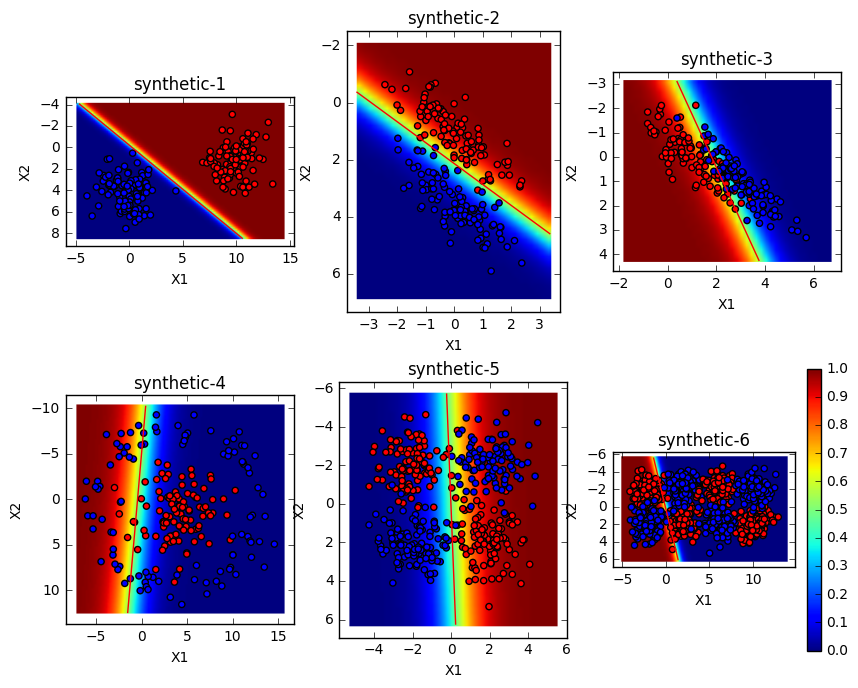

In [197]:
generateFigures(expansion_func=unravel, graphName="standard")
generateMisclassificationRates(unravel)

## Quadratic Featurespace
The following cell shows my misclassification rates and decision boundary using a quadratic featurespace, as mentioned in the program requirements. This featurespace seems to fit the first three datasets and the fifth one very well, but the misclassification rates don't reflect this. 

Misclassification for Synthetic-1: 0.393939393939
Misclassification for Synthetic-2: 0.409090909091
Misclassification for Synthetic-3: 0.515151515152
Misclassification for Synthetic-4: 0.5
Misclassification for Synthetic-5: 0.522727272727
Misclassification for Synthetic-6: 0.469696969697


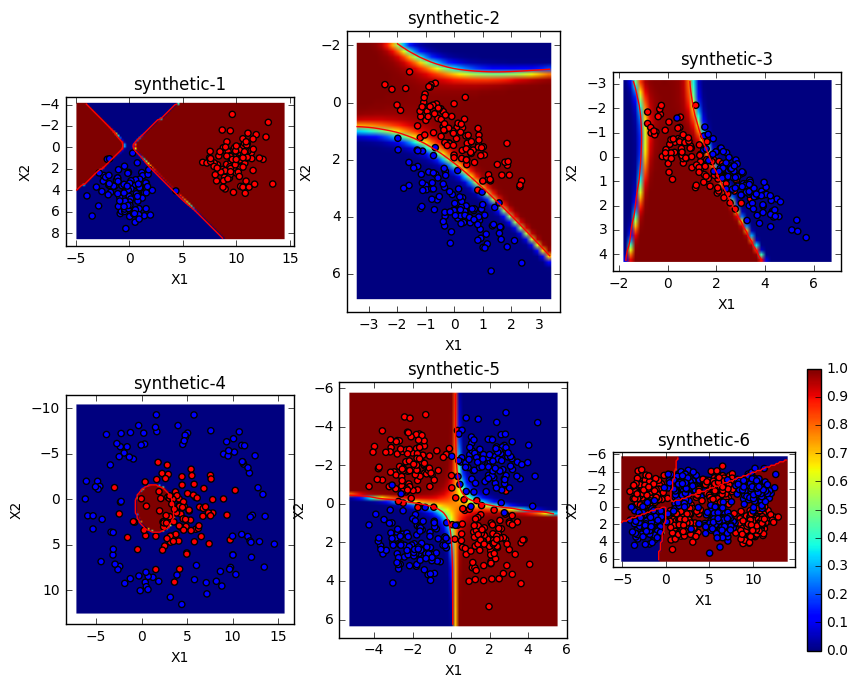

In [198]:
generateFigures(expansion_func=expandQuadratic, graphName="quadratic")
generateMisclassificationRates(expandQuadratic)

## Standard Features + XY
The cell below shows my graphs and misclassification rates for the standard featurespace with an added XY term. These features seem to fit the first 3 datasets and the fifth one fairly well. 

Misclassification for Synthetic-1: 0.409090909091
Misclassification for Synthetic-2: 0.409090909091
Misclassification for Synthetic-3: 0.515151515152
Misclassification for Synthetic-4: 0.469696969697
Misclassification for Synthetic-5: 0.545454545455
Misclassification for Synthetic-6: 0.518939393939


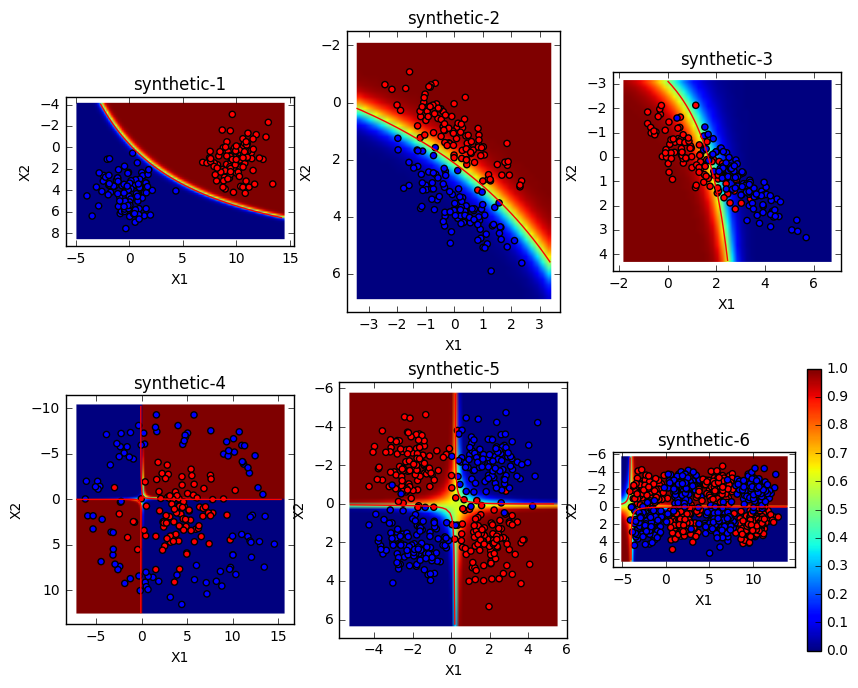

In [199]:
generateFigures(expansion_func=expandXY, graphName="XY Expansion")
generateMisclassificationRates(expandXY)

## XY + XY^2
This next one was part of my experiments to try to fit the sixth dataset as best I could. It appears to fit the second dataset really well, and the first one with a weird red region in the top right. It does a terrible job fitting the others.

Misclassification for Synthetic-1: 0.454545454545
Misclassification for Synthetic-2: 0.469696969697
Misclassification for Synthetic-3: 0.469696969697
Misclassification for Synthetic-4: 0.5
Misclassification for Synthetic-5: 0.530303030303
Misclassification for Synthetic-6: 0.481060606061


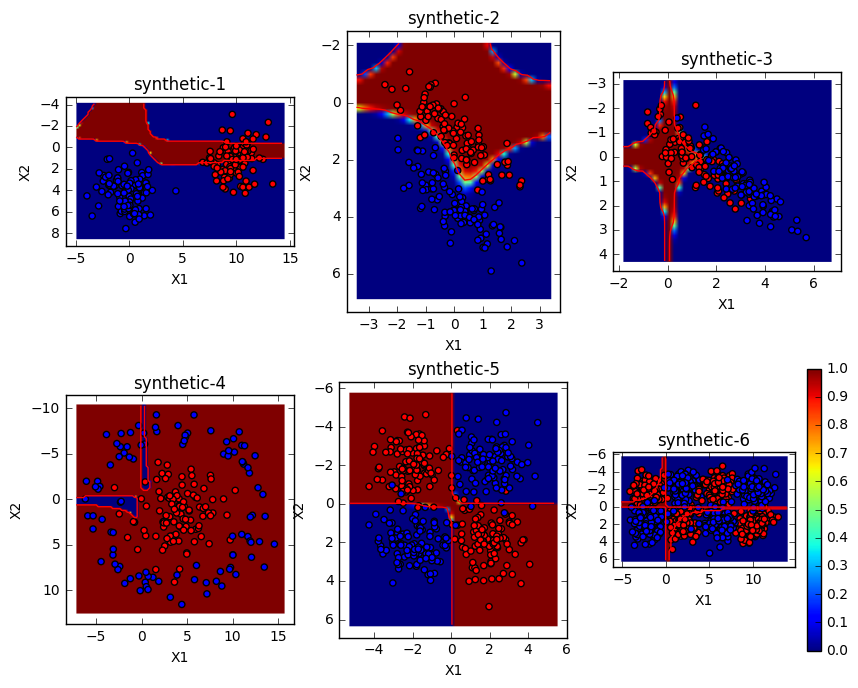

In [200]:
generateFigures(expansion_func=expandXYAndXYSquared, graphName="XY and XY Squared")
generateMisclassificationRates(expandXYAndXYSquared)

## Squared Expansion
This cell contains the standard feature space with a bias and the two features squared added as extra terms. These graphs are sort of similar to the previous set of features, but they don't fit the data as well (and have some of those weird regions with no datapoints that are marked a different color). 

Misclassification for Synthetic-1: 0.393939393939
Misclassification for Synthetic-2: 0.424242424242
Misclassification for Synthetic-3: 0.469696969697
Misclassification for Synthetic-4: 0.424242424242
Misclassification for Synthetic-5: 0.439393939394
Misclassification for Synthetic-6: 0.518939393939


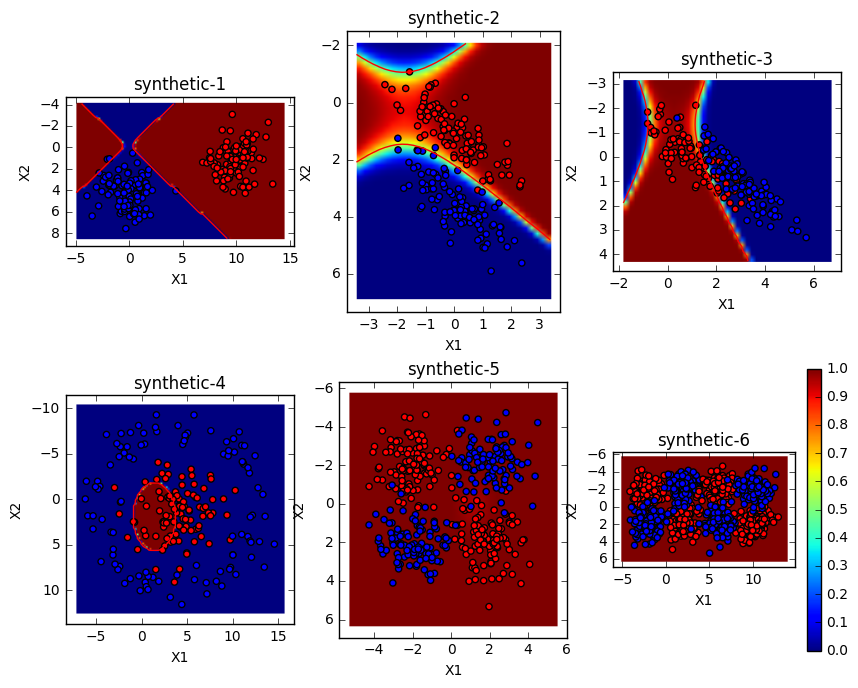

In [201]:
generateFigures(expansion_func=expandSquares, graphName="Squares")
generateMisclassificationRates(expandSquares)

## XY and Squares
This cell contains features containing the XY term, and X and Y squared individually. Similar to the graph above, with even less accuracy. 

Misclassification for Synthetic-1: 0.393939393939
Misclassification for Synthetic-2: 0.409090909091
Misclassification for Synthetic-3: 0.545454545455
Misclassification for Synthetic-4: 0.5
Misclassification for Synthetic-5: 0.522727272727
Misclassification for Synthetic-6: 0.465909090909


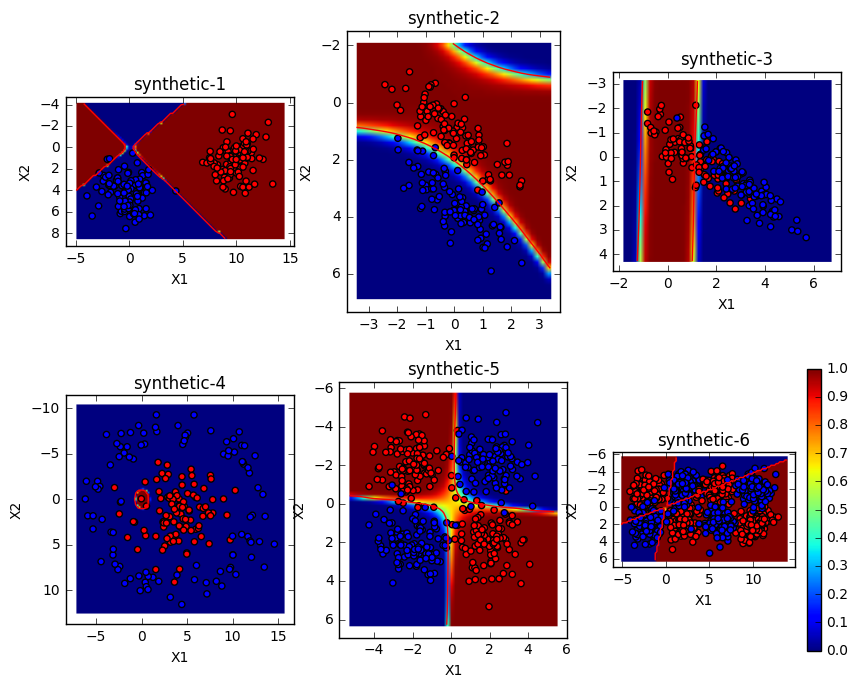

In [202]:
generateFigures(expansion_func=expandXYAndSquares, graphName="XY and Squares")
generateMisclassificationRates(expandXYAndSquares)

## Cubic Expansion
This is similar to the quadratic expansion, but with terms added (X**2 * Y**2, X**3, Y**3). These graphs have some smooth boundaries for the first and second graphs, with some weirdness in the third, insanity in the fourth, somewhat accuracy in the fifth, and garbage in the sixth. This was my last attempt to fitting the sixth dataset. 

Misclassification for Synthetic-1: 0.409090909091
Misclassification for Synthetic-2: 0.409090909091
Misclassification for Synthetic-3: 0.484848484848
Misclassification for Synthetic-4: 0.484848484848
Misclassification for Synthetic-5: 0.515151515152
Misclassification for Synthetic-6: 0.534090909091


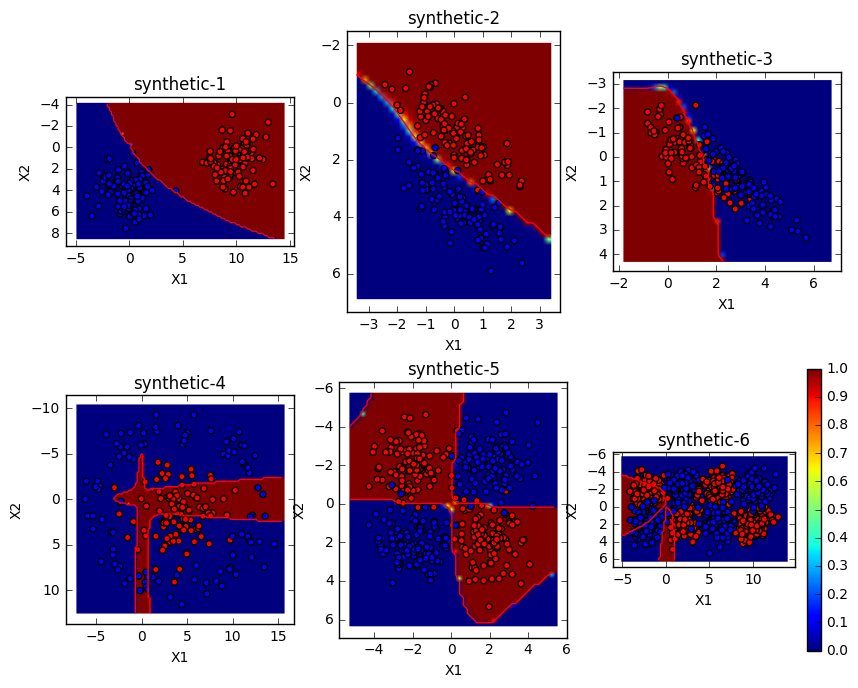

In [203]:
generateFigures(expansion_func=expandCubic, graphName="standard")
generateMisclassificationRates(expandCubic)